# Solving TSP Using Dynamic Programming

## This notebook was created to serve a [blog post](https://towardsdatascience.com/solving-tsp-using-dynamic-programming-2c77da86610d) by the same name.

In [1]:
import time
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def DP_TSP(distances_array):
    n = len(distances_array)
    all_points_set = set(range(n))

    # memo keys: tuple(sorted_points_in_path, last_point_in_path)
    # memo values: tuple(cost_thus_far, next_to_last_point_in_path)
    memo = {(tuple([i]), i): tuple([0, None]) for i in range(n)}
    queue = [(tuple([i]), i) for i in range(n)]

    while queue:
        prev_visited, prev_last_point = queue.pop(0)
        prev_dist, _ = memo[(prev_visited, prev_last_point)]

        to_visit = all_points_set.difference(set(prev_visited))
        for new_last_point in to_visit:
            new_visited = tuple(sorted(list(prev_visited) + [new_last_point]))
            new_dist = prev_dist + distances_array[prev_last_point][new_last_point]

            if (new_visited, new_last_point) not in memo:
                memo[(new_visited, new_last_point)] = (new_dist, prev_last_point)
                queue += [(new_visited, new_last_point)]
            else:
                if new_dist < memo[(new_visited, new_last_point)][0]:
                    memo[(new_visited, new_last_point)] = (new_dist, prev_last_point)

    optimal_path, optimal_cost = retrace_optimal_path(memo, n)

    return optimal_path, optimal_cost

In [3]:
def retrace_optimal_path(memo: dict, n: int) -> [[int], float]:
    points_to_retrace = tuple(range(n))

    full_path_memo = dict((k, v) for k, v in memo.items() if k[0] == points_to_retrace)
    path_key = min(full_path_memo.keys(), key=lambda x: full_path_memo[x][0])

    last_point = path_key[1]
    optimal_cost, next_to_last_point = memo[path_key]

    optimal_path = [last_point]
    points_to_retrace = tuple(sorted(set(points_to_retrace).difference({last_point})))

    while next_to_last_point is not None:
        last_point = next_to_last_point
        path_key = (points_to_retrace, last_point)
        _, next_to_last_point = memo[path_key]

        optimal_path = [last_point] + optimal_path
        points_to_retrace = tuple(sorted(set(points_to_retrace).difference({last_point})))

    return optimal_path, optimal_cost

In [4]:
def plot_route(X, optimal_path):
    for p1, p2 in zip(optimal_path[:-1], optimal_path[1:]):
        plt.plot([X[p1, 0], X[p2, 0]], [X[p1, 1], X[p2, 1]]);

In [5]:
def generate_random_input(n_points):
    X = np.random.rand(n_points, 2)
    distances_array = np.array([[np.linalg.norm(X[i] - X[j])
                                 for i in range(n_points)]
                                for j in range(n_points)])
    return X, distances_array

In [6]:
input_size = 12
X, distances_array = generate_random_input(input_size)

t = time.time()
optimal_path, optimal_cost = DP_TSP(distances_array)
runtime = round(time.time() - t, 3)

print(f"Found optimal path in {runtime} seconds.") 
print(f"Optimal cost: {round(optimal_cost, 3)}, optimal path: {optimal_path}") 

Found optimal path in 0.34 seconds.
Optimal cost: 2.484, optimal path: [5, 3, 0, 4, 1, 6, 10, 9, 8, 11, 7, 2]


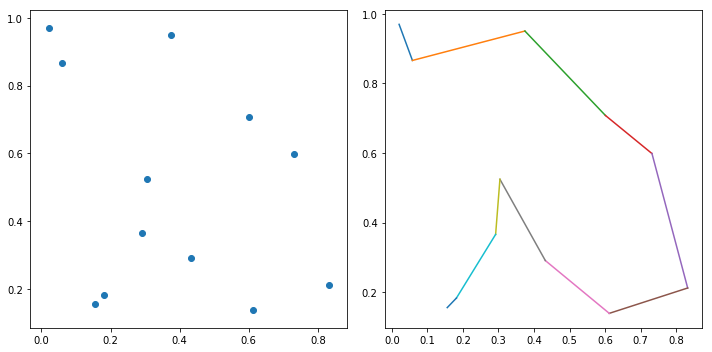

In [7]:
plt.figure(figsize=(10, 5));

plt.subplot(1, 2, 1);
plt.scatter(X[:, 0], X[:, 1]);

plt.subplot(1, 2, 2);
plot_route(X, optimal_path)

plt.tight_layout(); 

# Compare with YATS

### In a [previous post](https://medium.com/hackernoon/yats-yet-another-tsp-solution-6a71aeabe1f8), we solved TSP using a geometric trick + greedy local search.

### Now let's compare these two solutions!

In [8]:
import math
import random
random.seed(42)

class YATS:
    def __init__(self, n_iter: int = 100):
        self.n_iter = n_iter
        
    def get_best_route(self, points: np.array, distances_array: np.array) -> [[int], float]:
        optimal_path = self._get_angular_route(points)
        optimal_path = self._optimize_route(distances_array, optimal_path)
        optimal_cost = self._get_route_len(distances_array, optimal_path)
        return optimal_path, optimal_cost
    
    def _get_angular_route(self, points: np.array) -> [int]:
        center = np.mean(points, axis=0)
        route_idxs = sorted(list(range(len(points))),
                            key=lambda i:
                            self._get_angle_from_reference_point_in_deg(center, points[i, :]),
                            reverse=True)
        return route_idxs

    def _get_angle_from_reference_point_in_deg(self, reference_point: np.array, other_point: np.array) -> float:
        x, y = other_point - reference_point
        angle_from_reference_in_deg = math.degrees(math.atan2(y, x))
        return angle_from_reference_in_deg
    
    def _optimize_route(self, distances_array: np.array, route_idxs: [int]) -> [int]:
        prev_cost = self._get_route_len(distances_array, route_idxs)

        all_idxs = list(range(len(route_idxs)))
        for _ in range(self.n_iter):
            i1, i2 = random.sample(all_idxs, 2)
            route_idxs[i2], route_idxs[i1] = route_idxs[i1], route_idxs[i2]
            new_cost = self._get_route_len(distances_array, route_idxs)
            if new_cost < prev_cost:
                prev_cost = new_cost
            else:
                route_idxs[i2], route_idxs[i1] = route_idxs[i1], route_idxs[i2]
        return route_idxs

    def _get_route_len(self, distances_array: np.array, route_idxs: [int]):
        route_len = sum([distances_array[i1][i2]
                         for i1, i2 in zip(route_idxs[:-1], route_idxs[1:])])
        return route_len


In [9]:
yats = YATS()

t_yats = time.time()
optimal_path_yats, optimal_cost_yats = yats.get_best_route(X, distances_array)
runtime_yats = round(time.time() - t_yats, 3)

print(f"Found heuristic path in {runtime_yats} seconds.") 
print(f"Heuristic cost: {round(optimal_cost_yats, 3)}, heuristic optimal path: {optimal_path_yats}") 

Found heuristic path in 0.001 seconds.
Heuristic cost: 2.665, heuristic optimal path: [8, 3, 5, 0, 4, 1, 6, 10, 9, 11, 7, 2]


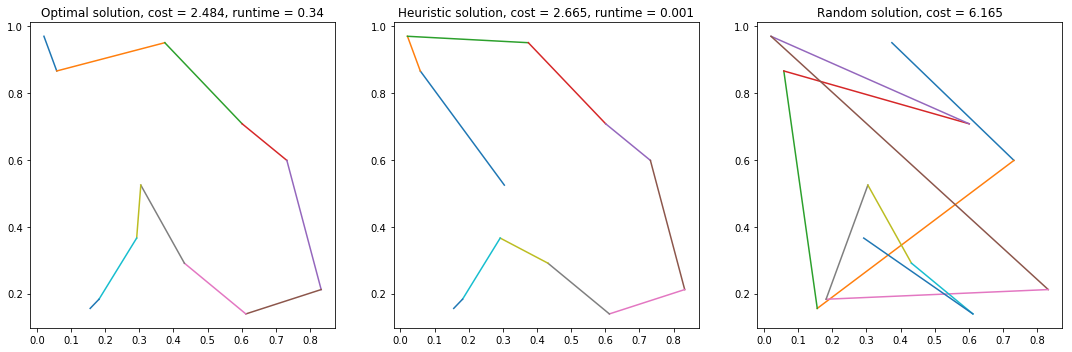

In [10]:
plt.figure(figsize=(15, 5));

plt.subplot(1, 3, 1);
plot_route(X, optimal_path)
plt.title(f"Optimal solution, cost = {round(optimal_cost, 3)}, runtime = {runtime}")

plt.subplot(1, 3, 2);
plot_route(X, optimal_path_yats)
plt.title(f"Heuristic solution, cost = {round(optimal_cost_yats, 3)}, runtime = {runtime_yats}")

plt.subplot(1, 3, 3);
random_path = list(range(len(X)))
random_cost = yats._get_route_len(distances_array, random_path)
plot_route(X, random_path)
plt.title(f"Random solution, cost = {round(random_cost, 3)}")

plt.tight_layout(); 

## OK now lets compare for different values

In [11]:
input_sizes = list(range(8, 19))
optimal_paths = []
optimal_costs = []
optimal_runtimes = []
heuristic_paths = []
heuristic_costs = []
heuristic_runtimes = []
random_paths = []
random_costs = []

for input_size in input_sizes:
    print(f"Finding paths for input of size {input_size}")
    X, distances_array = generate_random_input(input_size)

    t = time.time()
    optimal_path, optimal_cost = DP_TSP(distances_array)
    optimal_runtime = round(time.time() - t, 3)
    optimal_paths += [optimal_path]
    optimal_costs += [optimal_cost]
    optimal_runtimes += [optimal_runtime]

    print(f"Found optimal path in {optimal_runtime} seconds.") 
    print(f"Optimal cost: {round(optimal_cost, 3)}, optimal path: {optimal_path}") 
    
    yats = YATS()
    t_yats = time.time()
    heuristic_path, heuristic_cost = yats.get_best_route(X, distances_array)
    heuristic_runtime = round(time.time() - t_yats, 3)
    heuristic_paths += [heuristic_path]
    heuristic_costs += [heuristic_cost]
    heuristic_runtimes += [heuristic_runtime]

    print(f"Found heuristic path in {heuristic_runtime} seconds.") 
    print(f"Heuristic cost: {round(heuristic_cost, 3)}, heuristic optimal path: {heuristic_path}")
    
    random_path = list(range(input_size))
    random_cost = yats._get_route_len(distances_array, random_path)
    random_paths += [random_path]
    random_costs += [random_cost]
    
    print(f"Random cost: {round(random_cost, 3)}")
    print()


Finding paths for input of size 8
Found optimal path in 0.031 seconds.
Optimal cost: 2.388, optimal path: [4, 0, 1, 6, 2, 3, 7, 5]
Found heuristic path in 0.001 seconds.
Heuristic cost: 2.499, heuristic optimal path: [4, 1, 0, 5, 7, 3, 2, 6]
Random cost: 4.451

Finding paths for input of size 9
Found optimal path in 0.018 seconds.
Optimal cost: 2.466, optimal path: [4, 8, 0, 3, 2, 1, 7, 6, 5]
Found heuristic path in 0.001 seconds.
Heuristic cost: 2.903, heuristic optimal path: [1, 2, 7, 6, 5, 4, 8, 0, 3]
Random cost: 3.397

Finding paths for input of size 10
Found optimal path in 0.04 seconds.
Optimal cost: 2.399, optimal path: [5, 7, 4, 3, 0, 1, 9, 6, 2, 8]
Found heuristic path in 0.0 seconds.
Heuristic cost: 2.543, heuristic optimal path: [5, 7, 4, 3, 8, 2, 6, 9, 1, 0]
Random cost: 5.267

Finding paths for input of size 11
Found optimal path in 0.109 seconds.
Optimal cost: 2.125, optimal path: [6, 10, 2, 0, 3, 9, 8, 7, 4, 1, 5]
Found heuristic path in 0.0 seconds.
Heuristic cost: 2.1

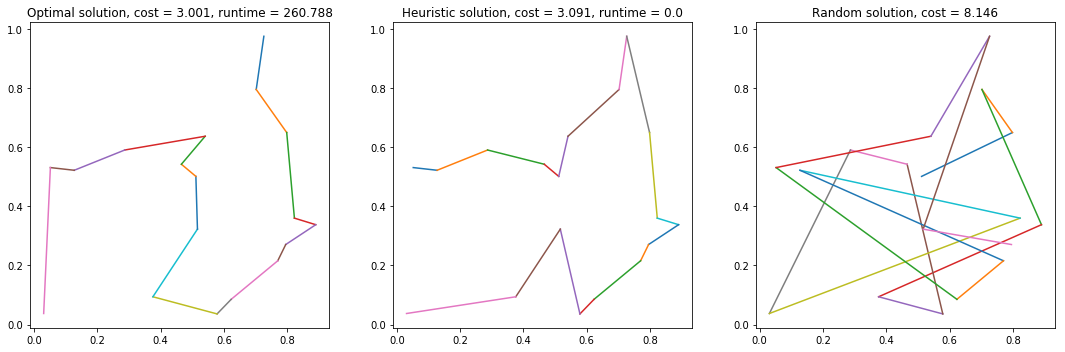

In [12]:
plt.figure(figsize=(15, 5));

plt.subplot(1, 3, 1);
plot_route(X, optimal_paths[-1])
plt.title(f"Optimal solution, cost = {round(optimal_costs[-1], 3)}, runtime = {optimal_runtimes[-1]}")

plt.subplot(1, 3, 2);
plot_route(X, heuristic_paths[-1])
plt.title(f"Heuristic solution, cost = {round(heuristic_costs[-1], 3)}, runtime = {heuristic_runtimes[-1]}")

plt.subplot(1, 3, 3);
plot_route(X, random_paths[-1])
plt.title(f"Random solution, cost = {round(random_costs[-1], 3)}")

plt.tight_layout(); 

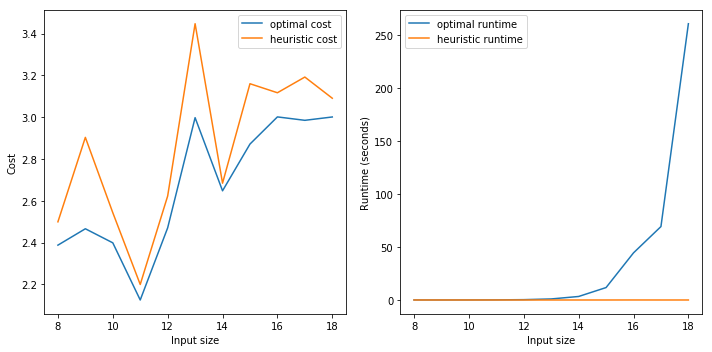

In [15]:
plt.figure(figsize=(10, 5));

plt.subplot(1, 2, 1);
plt.plot(input_sizes, optimal_costs);
plt.plot(input_sizes, heuristic_costs);
plt.xlabel("Input size");
plt.ylabel("Cost");
plt.legend(labels=["optimal cost", "heuristic cost"]);

plt.subplot(1, 2, 2);
plt.plot(input_sizes, optimal_runtimes);
plt.plot(input_sizes, heuristic_runtimes);
plt.xlabel("Input size");
plt.ylabel("Runtime (seconds)");
plt.legend(labels=["optimal runtime", "heuristic runtime"]);

plt.tight_layout(); 